# Analysis of the RL BR policies

In this notebook we explore the performance of BR policies trained on two different populations, `P0` and `P1`.

Progress:
- There is a clear generalization gap for the BR policies for each environment, with some minor exceptions
- The relationship between diversity and generalization gap is not clear. It's complicated. I hypothesize there are a two key factors: (1) population diversity, (2) population fitness, but how they affect generalization is not clear. I need to think about this more.



In [7]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from posggym_baselines.config import REPO_DIR

sys.path.insert(0, str(REPO_DIR / "baseline_exps"))
import exp_utils

sns.set_theme()
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")
# sns.set_palette("pastel")

SAVE_RESULTS = False

In [8]:
ALL_ENV_DATA = exp_utils.load_all_env_data()
for k in ALL_ENV_DATA:
    print(k)

NUM_ENVS = len(ALL_ENV_DATA)

# figure parameters
FIGSIZE = (10, 10)
N_COLS = min(3, NUM_ENVS)
N_ROWS = (NUM_ENVS // N_COLS) + int(NUM_ENVS % N_COLS > 0)

CooperativeReaching-v0
Driving-v1
LevelBasedForaging-v3
PredatorPrey-v0
PursuitEvasion-v1_i0
PursuitEvasion-v1_i1


## BR Policy Learning Curves

Here we plot the learning curves for the BR policies trained on `P0` and `P1` for each environment. 

We use a separate plot for each population for each environment, and plot each training seed as a separate line.

In [9]:
# This code cleans the raw data downloaded from wandb
# - removing weird names
# - removing the __MIN and __MAX columns
# - updating column names
# - reformating the data to use a seed column instead of separate columns for each seed
for full_env_id, env_data in ALL_ENV_DATA.items():
    for pop_id, results_file in env_data.rl_br_training_results_files.items():
        results_df = pd.read_csv(results_file)
        if "global_step" not in results_df.columns:
            # already cleaned
            continue
        
        columns_to_drop = []
        step_col_to_keep = None
        for col in results_df.columns:
            if col.endswith("__MIN") or col.endswith("__MAX"):
                columns_to_drop.append(col)
            elif col != "global_step" and col.endswith("_step"):
                if step_col_to_keep is None:
                    step_col_to_keep = col
                else:
                    columns_to_drop.append(col)
        results_df = results_df.drop(columns=columns_to_drop)

        column_rename_map = {}
        seeds = []
        for col in results_df.columns:
            if col == "global_step":
                column_rename_map[col] = "step"
            elif col.endswith("_step"):
                column_rename_map[col] = "update"
            else:
                # Format: BR-PPO_<env_id>[_agent_id]_<pop_id>_<seed>_<date>_<time> - policy_stats/BR/mean_episode_return
                # e.g. "BR-PPO_PursuitEvasion-v1_i1_P0_0_20240119_053338 - policy_stats/BR/mean_episode_return"
                assert col.endswith("/BR/mean_episode_return")
                tokens = col.split("_")
                env_token_idx = tokens.index(env_data.env_id)
                if tokens[env_token_idx + 1].startswith("i"):
                    seed = int(tokens[env_token_idx + 3])
                else:
                    seed = int(tokens[env_token_idx + 2])
                column_rename_map[col] = seed
                seeds.append(seed)

        results_df = results_df.rename(columns=column_rename_map)

        results_df = results_df.melt(
            id_vars=["step", "update"], 
            value_vars=seeds, 
            var_name="seed", 
            value_name="mean_episode_return"
        )
        results_df["seed"] = results_df["seed"].astype(int)
        
        results_df.to_csv(str(results_file), index=False)

In [10]:
# Import data
training_results_df = []
for full_env_id, env_data in ALL_ENV_DATA.items():
    env_pop_results_df = []
    for pop_id, results_file in env_data.rl_br_training_results_files.items():
        results_df = pd.read_csv(results_file)
        results_df["pop_id"] = pop_id
        env_pop_results_df.append(results_df)
    env_pop_results_df = pd.concat(env_pop_results_df)
    env_pop_results_df["full_env_id"] = full_env_id
    training_results_df.append(env_pop_results_df)

training_results_df = pd.concat(training_results_df)

full_env_ids = training_results_df["full_env_id"].unique().tolist()
full_env_ids.sort()
print("Full env ids:", full_env_ids)

pop_ids = training_results_df["pop_id"].unique().tolist()
pop_ids.sort()
print("Pop ids:", pop_ids)

seeds = training_results_df["seed"].unique().tolist()
seeds.sort()
print("Seeds:", seeds)

Full env ids: ['CooperativeReaching-v0', 'Driving-v1', 'LevelBasedForaging-v3', 'PredatorPrey-v0', 'PursuitEvasion-v1_i0', 'PursuitEvasion-v1_i1']
Pop ids: ['P0', 'P1']
Seeds: [0, 1, 2, 3, 4]


In [ ]:
# Plot data
pallete = {s: 'grey' for s in seeds}

for full_env_id, env_data in ALL_ENV_DATA.items():
    fig, axes = plt.subplots(
        nrows=1, 
        ncols=2, 
        figsize=(6, 3), 
        sharey=True,
        sharex=True,
    )
    env_df = training_results_df[training_results_df["full_env_id"] == full_env_id]
    for c, pop_id in enumerate(pop_ids):
        ax = axes[c]
        pop_df = env_df[env_df["pop_id"] == pop_id]
        sns.lineplot(
            data=pop_df,
            x="step",
            y="mean_episode_return",
            hue="seed",
            palette=pallete,
            ax=ax,
            legend=False,
            alpha=0.5,
            linewidth=0.5,
        )

        sns.lineplot(
            data=pop_df,
            x="step",
            y="mean_episode_return",
            ax=ax,
            color=sns.color_palette()[0],
            legend=False,
            errorbar=None,
            linewidth=0.75,
        )

        # Set axis labels
        ax.set_ylabel("Mean Return")
        ax.set_xlabel("Training Step")
        ax.set_title(pop_id)

    fig.tight_layout()
    # if SAVE_RESULTS:
    if True:
        fig.savefig(str(env_data.env_data_dir / "rl_br_learning_curve.pdf"))
    fig.suptitle(full_env_id)
    fig.subplots_adjust(top=0.8)


## BR Policy Performance against Train and Test populations

In [16]:
br_results_df = []
for full_env_id, env_data in ALL_ENV_DATA.items():
    env_br_results_df = pd.read_csv(env_data.rl_br_results_file)
    env_br_results_df["full_env_id"] = full_env_id
    br_results_df.append(env_br_results_df)

br_results_df = pd.concat(br_results_df, ignore_index=True)
br_results_df.rename(
    columns={
        "train_pop": "Train Population",
        "test_pop": "Test Population",
        "return": "Mean Return",
    },
    inplace=True,
)

# Add In/Out of Distribution labels
def get_in_out_dist_label(row):
    return row["Train Population"] == row["Test Population"]

br_results_df["In Distribution"] = br_results_df.apply(
    get_in_out_dist_label, axis=1
)


br_results_df.sort_values(
    by=[
        "full_env_id", 
        "Train Population", 
        "Test Population"
    ], 
    inplace=True
)

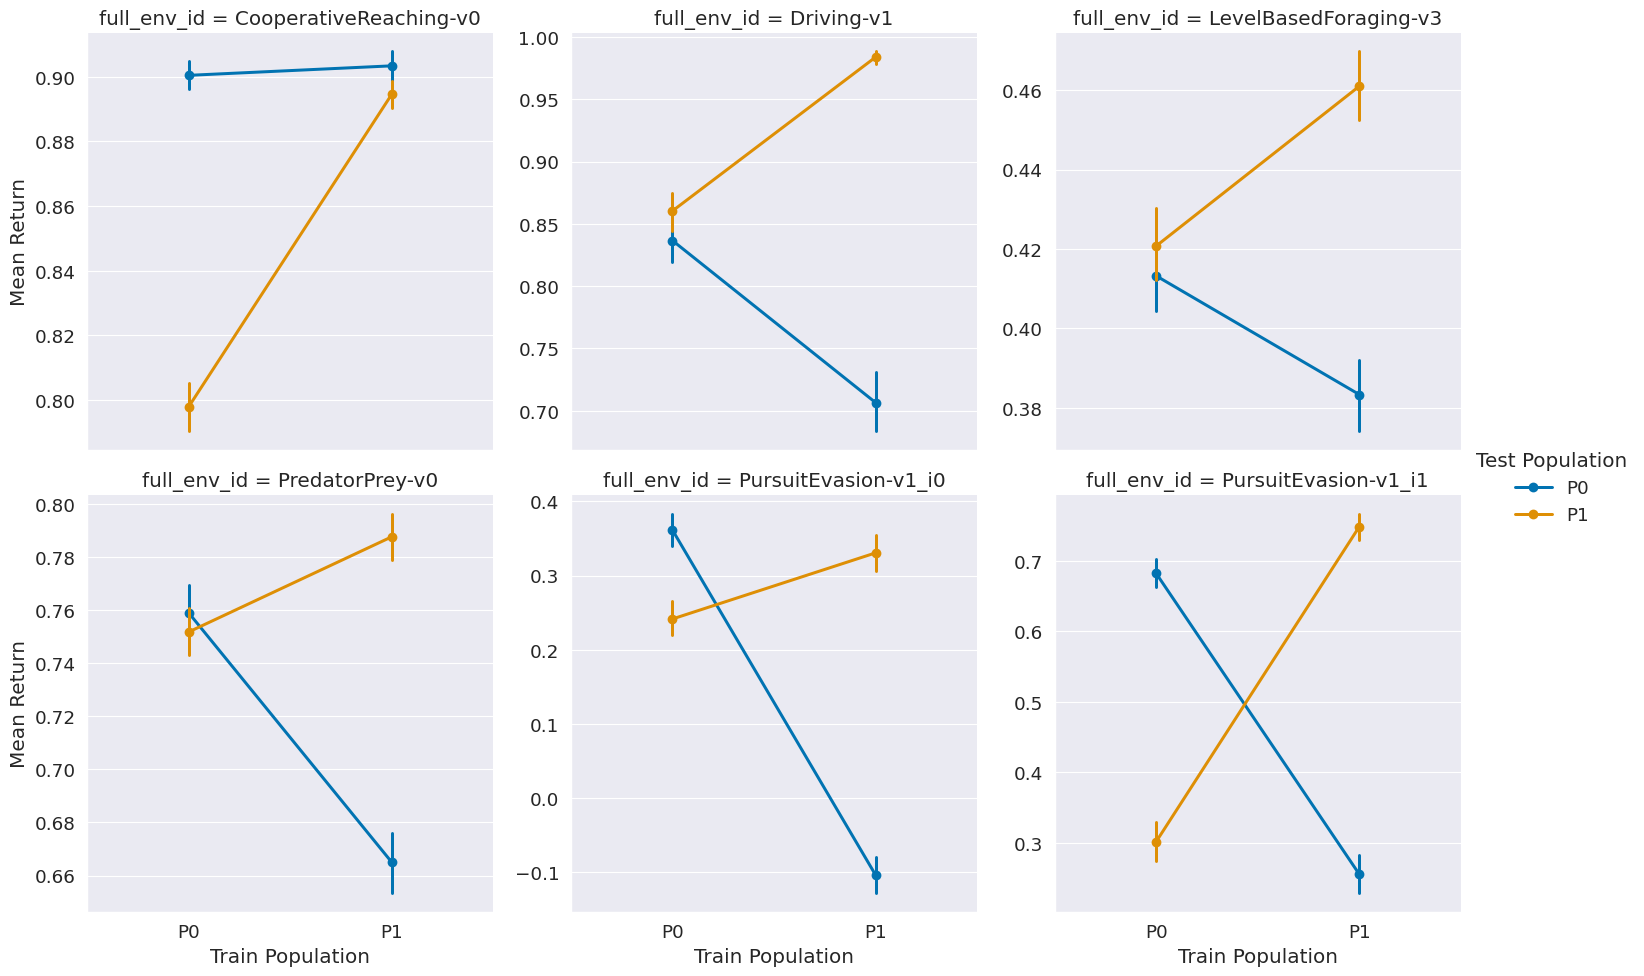

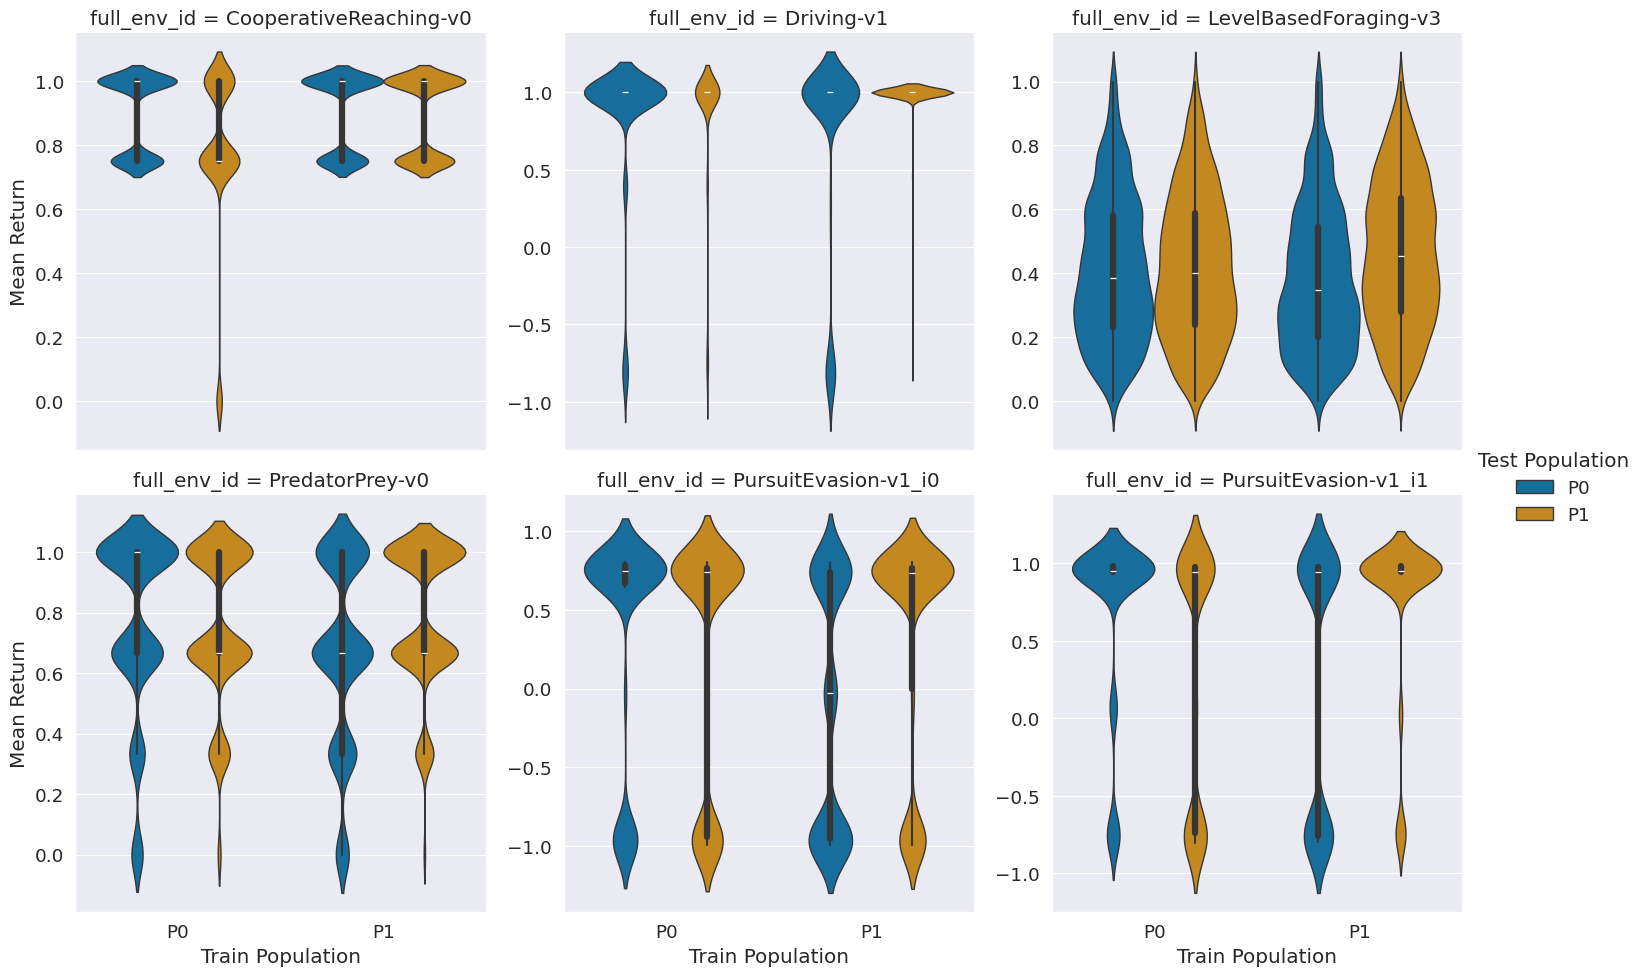

In [17]:
for kind in ("point", "violin"):
    kwargs = {}
    if kind == "bar":
        kwargs["capsize"] = 0.1
    elif kind == "violin":
        kwargs["cut"] = 2

    plot = sns.catplot(
        data=br_results_df,
        x="Train Population",
        y="Mean Return",
        hue="Test Population",
        col="full_env_id",
        col_wrap=N_COLS,
        kind=kind,
        sharey=False,
        **kwargs
    )

    if SAVE_RESULTS:
        plot.figure.savefig(
            exp_utils.ENV_DATA_DIR / f"rl_br_P0vP1_by_env_results_{kind}.png", 
            bbox_inches="tight"
        )

    del plot

## BR Policy In-Distribution vs Out-of-Distribution Performance 

In [ ]:
for kind in ("bar", "violin"):
    kwargs = {}
    if kind == "bar":
        kwargs["capsize"] = 0.1
    elif kind == "violin":
        kwargs["cut"] = 0

    plot = sns.catplot(
        data=br_results_df,
        x="In Distribution",
        y="Mean Return",
        col="full_env_id",
        col_wrap=N_COLS,
        kind=kind,
        sharey=False,
        **kwargs
    )

    # plot.set_xticklabels(rotation=90)

    # if SAVE_RESULTS:
    if True:
        plot.figure.savefig(
            exp_utils.ENV_DATA_DIR / f"rl_br_idvood_by_env_results_{kind}.pdf", 
            bbox_inches="tight"
        )

    plot.figure.tight_layout()
    del plot

## BR Policy Generalization Gap

The generalization gap of the BR Policy is the difference in performance between the train and test populations. We calculate this by taking the difference between the mean performance of the train and test populations.

Specifically, for each seed, we calculate the mean performance of the train and test populations. Then, we take the difference between the two means. Finally, we take the mean of the differences across all seeds.

In [ ]:
gg_df = br_results_df[
    br_results_df["In Distribution"] == True  # noqa: E712
].merge(
    br_results_df[br_results_df["In Distribution"] == False],    # noqa: E712
    on=["env_id", "full_env_id", "train_seed", "Train Population"],
    suffixes=("", "_test"),
)

gg_df["Generalization Gap"] = gg_df["Mean Return_test"] - gg_df["Mean Return"]

for kind in ("bar", "violin"):
    gg_plot = sns.catplot(
        data=gg_df,
        x="Train Population",
        y="Generalization Gap",
        col="full_env_id",
        col_wrap=N_COLS,
        kind=kind,
        sharey=True,
    )
    gg_plot.refline(x=None, y=0.0, linestyle="-")

## Population Diversity

We calculate the diversity of a population of policies by taking the mean of the pairwise distances between the returns of all policies in the population. We use the Euclidean distance as our distance metric.

In [ ]:
# Plot all features together
# x = "Mean Pairwise L2 Distance"
# y = "Generalization Gap"
# hue/z = "Mean Pairwise Return"

# Get BR results averaged across seeds
all_df = br_results.groupby(
    ["full_env_id", "Train Population", "Test Population"]
).agg(
    {"Mean Return": "mean"}
).reset_index()

all_df.sort_values(by=["full_env_id", "Train Population", "Test Population"], inplace=True)

all_df["Train"] = all_df.apply(lambda row: row["Train Population"] == row["Test Population"], axis=1)


pop_df = all_df[
    all_df["Train"] == True  # noqa: E712
].merge(
    all_df[all_df["Train"] == False],    # noqa: E712
    on=["full_env_id", "Train Population"],
    suffixes=("", "_test"),
)
pop_df["Generalization Gap"] = pop_df["Mean Return_test"] - pop_df["Mean Return"]
# pop_df

div_df = pop_div_results[
    ["Env ID", "Population", "Mean Pairwise L2 Distance", "Mean Pairwise Return"]
].copy()

pop_df = pop_df.merge(
    div_df,
    left_on=["full_env_id", "Train Population"],
    right_on=["Env ID", "Population"],
    suffixes=("", "_div"),
)
pop_df.drop(columns=["Env ID", "Population"], inplace=True)

# drop PursuitEvasion-v1_i0 and PursuitEvasion-v1_i1
pop_df = pop_df[pop_df["full_env_id"] != "PursuitEvasion-v1_i0"]
pop_df = pop_df[pop_df["full_env_id"] != "PursuitEvasion-v1_i1"]

sns.scatterplot(
    data=pop_df,
    x="Mean Pairwise L2 Distance",
    y="Generalization Gap",
    hue="Mean Pairwise Return",
    palette="YlGnBu",
    size="Mean Pairwise Return",
    sizes=(50, 200),
)

pop_df
